In [2]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [4]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Loading data

In [5]:
# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_aa/aa_data_train.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_aa/mic_aa_train_rif.csv')
# train_target = train_target[['RIF_MIC']]
# # don't touch test data, split out validation data from training data during training
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_aa/aa_data_test.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_aa/mic_aa_test_rif.csv')
# test_target = test_target[['RIF_MIC']]

In [6]:
# new data
train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_train.csv', delimiter = ',')
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_train.csv')
train_target = train_target[['RIF_MIC']]
# don't touch test data, split out validation data from training data during training
test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_test.csv', delimiter = ',')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_test.csv')
test_target = test_target[['RIF_MIC']]

In [30]:
train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_train.csv', delimiter = ',')


In [7]:
train_data[0].shape

(14954,)

In [8]:
# valid_indices = train_target.dropna().index
# train_target = train_target.loc[valid_indices]
# train_data = train_data[valid_indices]

# valid_indices = test_target.dropna().index
# test_target = test_target.loc[valid_indices]
# test_data = test_data[valid_indices] 

In [9]:
N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)

# Feature engineering

In [10]:
# def one_hot_torch(seq: str, dtype=torch.int8):
#     seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
#     acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#     arr = torch.zeros(6, (len(seq_bytes)), dtype=dtype)
#     arr[0, seq_bytes == acgt_bytes[0]] = 1
#     arr[1, seq_bytes == acgt_bytes[1]] = 1
#     arr[2, seq_bytes == acgt_bytes[2]] = 1
#     arr[3, seq_bytes == acgt_bytes[3]] = 1
#     arr[4, seq_bytes == acgt_bytes[3]] = 1
#     arr[5, seq_bytes == acgt_bytes[3]] = 1
#     return arr



# def one_hot_torch(category: int, num_categories: int = 6, dtype=torch.int8):
#     # Ensure the category is valid
#     category -= 1
#     if not (0 <= category < num_categories):
#         raise ValueError("Category out of range")

#     # Create a tensor of zeros with shape (num_categories,)
#     arr = torch.zeros(num_categories, dtype=dtype)
    
#     # Set the corresponding category index to 1
#     arr[category] = 1
#     return arr

# def one_hot_torch(seq):
#     oh = []
#     for sample in seq:
#         sample = torch.ByteTensor(list(bytes(sample, "utf-8")))
#         acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#         arr = torch.zeros((len(sample), 4), dtype=torch.int8)
#         arr[sample == acgt_bytes[0], 0] = 1
#         arr[sample == acgt_bytes[1], 1] = 1
#         arr[sample == acgt_bytes[2], 2] = 1
#         arr[sample == acgt_bytes[3], 3] = 1
#         oh.append(arr)
#     return torch.stack(oh)

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )



# Dateset

In [11]:
# Julian's code - implement this, might be faster
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0), torch.tensor(res)
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=True)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

###  Split for multiclass labels

In [10]:
from torch.utils.data import Subset

dataset_size = len(training_dataset)
dataset_indices = list(range(dataset_size))

labels = np.array([training_dataset[i][1] for i in range(len(training_dataset))])
# labels = labels.astype(float)  # or .astype(int), depending on your specific case
tensor_list = labels  # Replace `array` with the actual variable name if different

# Convert each tensor to a numpy array and collect them in a list
numpy_arrays = [tensor.cpu().numpy() if tensor.requires_grad else tensor.numpy() for tensor in tensor_list]

# Stack the numpy arrays into a 2D numpy array
labels = np.vstack(numpy_arrays)
labels[np.isnan(labels)] = -10


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# Assuming you have a numpy array `labels` where each row corresponds to the multi-labels for an entry
# For example, labels could be a 2D array where each entry has multiple labels, one for each drug MIC

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1111, random_state=42)

# Since MultilabelStratifiedShuffleSplit works with indices, we generate an index array
indices = np.arange(len(labels))

# msss.split returns indices for train and test based on the stratification of the labels
for train_index, test_index in msss.split(indices, labels):
    train_indices, test_indices = train_index, test_index

# Now, you have train_indices and test_indices that you can use to create subsets as before
train_dataset = Subset(training_dataset, train_indices)
test_dataset = Subset(training_dataset, test_indices)

/tmp/ipykernel_127928/141369023.py:6: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  labels = np.array([training_dataset[i][1] for i in range(len(training_dataset))])
/tmp/ipykernel_127928/141369023.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.array([training_dataset[i][1] for i in range(len(training_dataset))])


ValueError: Supported target type is: multilabel-indicator. Got 'binary' instead.

### Weighted masked loss

In [45]:
column_weight_maps

{'RIF_MIC': {0.03: 0.030575915412337295,
  0.12: 0.03330093710217665,
  0.25: 0.09693034272279312,
  0.5: 0.375670571525636,
  4.0: 0.43167115361641406,
  8.0: 0.03185107962064283}}

In [12]:
y_true = pd.concat([train_target, test_target])  # Your MIC values

column_weight_maps = {}

for i, column in enumerate(y_true.columns):
    # Extract the values for the current column
    column_values = y_true[column].values
    column_values = column_values[~np.isnan(column_values)]
    # Calculate frequencies of each MIC value in the column
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    # weights_inverse = 1 / frequency #! more for extreme imbalanced cases
    weights_inverse = 1 / frequency #! more for less extremely  imbalanced cases
    
    # Normalize weights to ensure they sum up to 1 (optional but recommended for stability)
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight for the current column
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    # Store the weight map for the current column
    column_weight_maps[column] = weight_map
    
def get_weighted_masked_loss(loss_fn, column_weight_maps):
    """
    Returns a loss function that ignores NaN values and applies weights from the corresponding column weight maps.

    :param loss_fn: A loss function compatible with the data (e.g., MSELoss for regression).
    :param column_weight_maps: A dictionary where keys are column indices and values are dictionaries mapping y_values to weights.
    """

    def weighted_masked_loss(y_pred, y_true):
        non_nan_mask = ~torch.isnan(y_true)
        weighted_losses = []
        # Iterate through each column, apply weights, and calculate the loss
        for col_idx in range(y_true.shape[1]):

            # Mask and select non-NaN values and predictions for the current column
            col_non_nan_mask = non_nan_mask[:, col_idx]
            y_true_col_non_nan = y_true[col_non_nan_mask, col_idx]
            y_pred_col_non_nan = y_pred[col_non_nan_mask, col_idx]

            # Retrieve the weight map for the current column
            col_weight_map = column_weight_maps[list(column_weight_maps)[col_idx]]
            mean_weight = np.mean(list(column_weight_maps[list(column_weight_maps)[col_idx]].values())) # just in case if a number is not recognised and the loss doesn't go crazy
            # Get weights for each non-NaN value in the current column
            weights_col = torch.tensor([col_weight_map.get(round(y.item(),2), mean_weight) for y in y_true_col_non_nan], dtype=torch.float32, device=y_true.device)

            # Calculate the loss for the current column
            col_loss = loss_fn(y_pred_col_non_nan, y_true_col_non_nan)
            # print(y_true_col_non_nan)
            # print(weights_col)
            # print('==========')
            # print(col_loss)
            # print('==========')
            # print(weights_col)
            # Weight the loss and store
            weighted_col_loss = weights_col * col_loss
            weighted_losses.append(weighted_col_loss)

        # Concatenate weighted losses from all columns, calculate mean over all non-NaN entries
        total_weighted_loss = torch.cat(weighted_losses).mean()

        return total_weighted_loss

    return weighted_masked_loss

        
masked_weighted_MAE = get_weighted_masked_loss(torch.nn.L1Loss(reduction='none'), column_weight_maps)
masked_weighted_MSE = get_weighted_masked_loss(torch.nn.MSELoss(reduction='none'), column_weight_maps)

### Masked loss

In [13]:

def get_masked_loss(loss_fn):
    """
    Returns a loss function that ignores NaN values
    """

    def masked_loss(y_true, y_pred):
        y_pred = y_pred.view(-1, 1)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # ic(y_pred.shape)
        # ic(y_true.shape)
        non_nan_mask = ~y_true.isnan()
        # ic(non_nan_mask)
        y_true_non_nan = y_true[non_nan_mask]
        y_pred_non_nan = y_pred[non_nan_mask]
        return loss_fn(y_pred_non_nan, y_true_non_nan)

    return masked_loss

masked_MAE = get_masked_loss(nn.L1Loss())


# Model

In [14]:
def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")

In [17]:

torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1.5,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        
        #dynamic filter scaling from deepram
        current_num_filters = num_filters
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters, int(current_num_filters * filter_scaling_factor), 3)
            self.conv_layers.append(layer)
            current_num_filters = int(current_num_filters * filter_scaling_factor)

        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers:
            x = layer(x)
        # global max pool 1D
        x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

model = Model(
num_classes=1,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0

epoch = 100
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-4

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
criterion = masked_weighted_MSE
# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

In [19]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn = get_weighted_masked_cross_entropy_loss(column_weight_maps['RIF_MIC'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

In [20]:

torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters2]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        
        x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=0.05,
dense_dropout_rate=0
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

epoch = 200
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-5

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion = weighted_cross_entropy_loss_fn

# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo

# Training

### Training

In [16]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        loss_train = criterion(pred,y_batch)
        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.float().to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = criterion(pred,y_batch)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_mae-binned-rif_newdata' ,epoch, lr=1e-4, fcdr=0.2, l2=1e-9, cnndr=0, train_loss = train_epoch_loss, test_loss = test_epoch_loss)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
print(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')

# torch.save({
#     'optimizer': optimizer.state_dict(),
#     'model': model.state_dict(),
# }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

  1%|          | 1/100 [00:10<17:17, 10.48s/it]

Epoch 1
Training loss: 1.1203160285949707
Validation loss: 1.0695068836212158


  1%|          | 1/100 [00:13<22:14, 13.48s/it]


KeyboardInterrupt: 

./graphs1/loss_lr_0.0001.png


/tmp/ipykernel_48980/4118118722.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


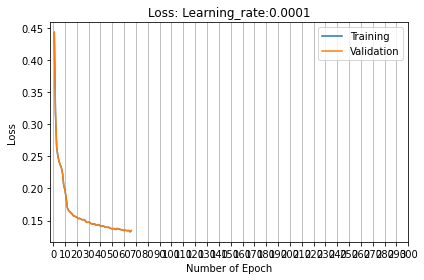

In [ ]:

fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, len(np.array(train_epoch_loss).flatten())+1, 1)
ax.plot(x, np.array(train_epoch_loss).flatten(),label='Training')
ax.plot(x, np.array(train_epoch_loss).flatten(),label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
print(f'./graphs1/loss_lr_{lr}.png')

## AUC

NameError: name 'cnn_dr' is not defined

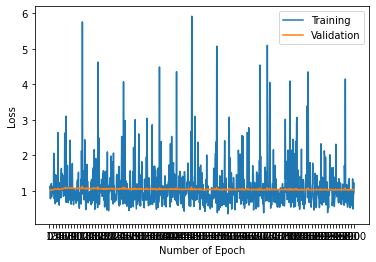

In [ ]:
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()

In [ ]:
test_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_padded_batch ,num_workers=8)

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

model.load_state_dict(torch.load('saved_weights/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

output = []
model.eval()
with torch.no_grad():

    for x, y in test_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        output.append(pred)
        
original_value_output = np.exp(output)

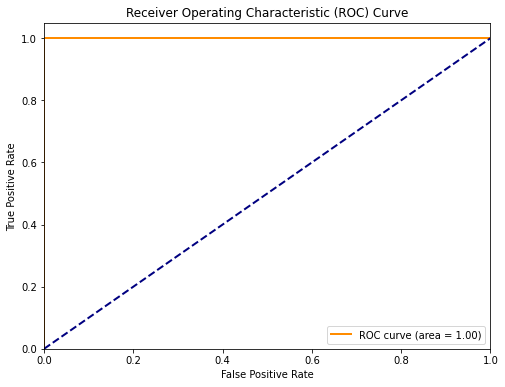

AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_auc(labels, scores):
    """
    Calculate the Area Under the Receiver Operating Characteristic Curve (AUC)
    given true binary labels and prediction scores.
    
    :param labels: List of true binary labels (0 or 1).
    :param scores: List of prediction scores (probabilities or continuous output of the model).
    :return: AUC score.
    """
    auc_score = roc_auc_score(labels, scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

# Example usage
true_labels = [0, 1, 1, 0, 1]  # True binary labels
prediction_scores = [0.1, 0.4, 0.8, 0.3, 0.7]  # Prediction scores or probabilities

auc_score = calculate_auc(true_labels, prediction_scores)
print(f"AUC Score: {auc_score}")

# testing out hyper-parameters

In [40]:
import subprocess

def run_bash_command(command):
    """
    Runs a bash command and returns its output.
    
    :param command: The command to run as a string.
    :return: A tuple containing the command's stdout and stderr.
    """
    try:
        # Run command
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Return stdout and stderr
        return result.stdout, result.stderr
    except subprocess.CalledProcessError as e:
        # Handle errors in the called executable
        return e.stdout, e.stderr
    except Exception as e:
        # Handle other errors related to subprocess.run()
        return None, str(e)

# Example usage
stdout, stderr = run_bash_command('nvidia-smi')
print('STDOUT:', stdout)
print('STDERR:', stderr)

# Example of a command that generates an error
stdout, stderr = run_bash_command('ls non_existent_file')
print('STDOUT:', stdout)
print('STDERR:', stderr)

STDOUT: Wed Mar 27 14:12:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |   1221MiB / 32510MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


In [48]:

def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")
        
def hyper_params_test(appendix, lr, fc_dr=0,cnn_dr=0, l2=0, epoch=50):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '| l2:', l2, '==='*10)
    torch.cuda.empty_cache()
    import gc; gc.collect()
    ic.disable()
    
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    # model = Model(
    # num_classes=13,
    # num_filters=128,
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64
    # num_dense_layers=2,
    # return_logits=True,
    # dense_dropout_rate=fc_dr,
    # conv_dropout_rate=cnn_dr
    # ).to(device)
    
    model = Model(
    num_classes=1,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=256, # batch_size = 64
    # num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=cnn_dr,
    dense_dropout_rate=fc_dr
    ).to(device)

    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    
    epoch = epoch
    batch_size = 128
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch)
    # criterion = nn.MSELoss()
    criterion = masked_weighted_MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    
    ic.disable()
    # ic.enable()
    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        for x, y in train_loader:
            x_batch = torch.squeeze(x, 0).to(device)
            y_batch = y.to(device)
            x_batch = x_batch.float()
            y_batch = y_batch.float()
            pred = model(x_batch.float())
            loss_train = criterion(pred,y_batch)
            ic(loss_train)
            train_batch_loss.append(loss_train)
    
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')
        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        with torch.no_grad():
            # print('test')
            for x, y in test_loader:
                x_batch = x.to(device)
                y_batch = y.to(device)
                pred = model(x_batch.float())
                loss_test = criterion(pred,y_batch)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    
     #! testing benchmark
    testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
    testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

    # drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    drugs = ['AMI_MIC','EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC']

    model.eval()
    pred_list = []
    target_list = []
    mse_list = []
    with torch.no_grad():
        for x_test, y_test in testing_loader1:
            xtest1 = x_test.to(device).float()
            ytest1 = y_test.to(device).float()
            pred = model(xtest1)
            pred_list.append(pred.detach().cpu().numpy()) 
            target_list.append(y_test.detach().cpu().numpy())

    pred_list = np.array(pred_list).squeeze()
    target_list = np.array(target_list).squeeze()
    mse_list = (pred_list - target_list)**2
    mse_out = np.nanmean(mse_list, axis=0)

    result = find_range_vectorized(target_list, pred_list)

    # Append output to a file
    with open('trials3.txt', 'a') as f:
        mse_drug_output = f"====MIC-mse: {drugs} {np.mean(mse_out)}\n"
        f.write(mse_drug_output)        
        ea_accuracy_output = f"====EA-accuracy: {drugs} {np.nanmean(result, axis=0)}\n"
        f.write(ea_accuracy_output)
        print(mse_drug_output)
        print(ea_accuracy_output)
        # for x, y in zip(drugs, np.nanmean(result, axis=0).tolist()):
        #     print(x, y)        
            
            
    x = np.arange(1, epoch+1, 1)
    fig, ax = plt.subplots(facecolor = 'white')
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, fc_dr:{fc_dr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}_l2{l2}_weighted_balanced.png')
    save_to_file('trials3.txt', appendix ,epoch, lr, cnn_dr, fc_dr, l2, train_epoch_loss, test_epoch_loss)
    print(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}_l2{l2}_weighted_balanced.png')
    
    torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}_weighted_balanced.pth')

In [42]:
train_data.shape

(6844, 14954)

lr: 1e-05 | fc_dr: 0 | cnn_dr: 0 | l2: 0 ==============================


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [1:03:12<00:00, 12.64s/it]


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.4557822195553125

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 0.5558475689881734

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new_loss_lr_1e-05_cnn_dr_0_fc_dr_0_l20_weighted_balanced.png
lr: 1e-06 | fc_dr: 0 | cnn_dr: 0 | l2: 0 ==============================


/tmp/ipykernel_66083/1241917742.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 300/300 [1:19:12<00:00, 15.84s/it]


====MIC-mse: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 1.580435074968998

====EA-accuracy: ['AMI_MIC', 'EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC'] 0.5519053876478318

./graphs2/aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new_loss_lr_1e-06_cnn_dr_0_fc_dr_0_l20_weighted_balanced.png


/tmp/ipykernel_66083/1241917742.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


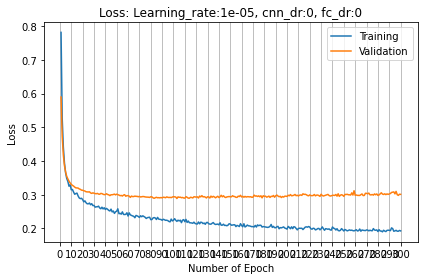

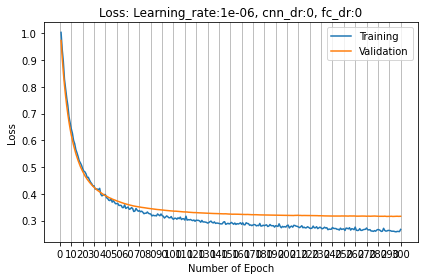

In [50]:
torch.cuda.empty_cache()
import gc; gc.collect()

# epoch = 250
# for lr in [1e-4]:
#     for fc_dr in [0.2]:
#         for decay in [1e-9]:
#             for cnn_dr in [0.2, 0.3, 0.4, 0.5]:
#                 hyper_params_test('64-2-256-2-128-log-reg-weighted_balanced', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)

epoch = 300
for lr in [ 1e-5, 1e-6]:
    for fc_dr in [0]:
        for decay in [0]:
            hyper_params_test('aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)
# epoch = 44
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0.4]:
#             for decay in [1e-8]:
#                 hyper_params_test('final_model', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

# epoch = 50
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0, 0.2, 0.3, 0.4, 0.5]:
#             for decay in [1e-8]:
#                 hyper_params_test('64-2-256-2-128-log-reg', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

ValueError: x and y must have same first dimension, but have shapes (2,) and (80,)

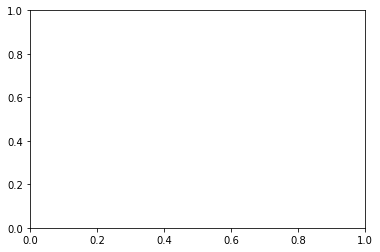

In [20]:
#%%
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")

# Testing

In [24]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader = DataLoader(dataset=testing_dataset, batch_size=128, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

## batch running

In [ ]:

save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference
# or
# model.train()  # For further training


pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader:
        x_batch = torch.squeeze(x_test, 0).to(device)
        x_batch = x_batch.float()
        y_batch = y_test.float().to(device)
        # print(x_batch.size())
        # y_batch = torch.Tensor.float(y).to(device)
        # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
        pred = model(x_batch.float())
        pred_list.append(pred)
        target_list.append(y_batch)
        # pred = pred.unsqueeze(0)
        loss_test = criterion(y_batch, pred)
        mse_list.append(loss_test)
        # test_batch_loss.append(loss_test)
        # test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())


## Overall test

In [134]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

#### for in memory model

In [99]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

ordinal data

In [103]:
np.array(target_list).flatten()

array([0.03, 0.12, 8.  , 8.  , 8.  , 0.12, 0.03, 8.  , 0.03, 0.03, 0.03,
       8.  , 0.03, 0.03, 0.25, 0.03, 0.12, 8.  , 0.03, 8.  , 0.12, 0.12,
       8.  , 0.12, 8.  , 8.  , 8.  , 0.12, 0.12, 0.12, 0.03, 0.03, 0.12,
       0.03, 0.12, 8.  , 8.  , 8.  , 0.25, 0.25, 8.  , 8.  , 0.12, 0.03,
       0.03, 0.25, 0.03, 0.03, 0.5 , 0.03, 8.  , 8.  , 8.  , 8.  , 8.  ,
       0.03, 0.12, 8.  , 8.  , 0.03, 0.25, 0.12, 8.  , 0.12, 0.03, 0.03,
       0.03, 0.12, 0.03, 0.03, 8.  , 0.03, 8.  , 0.25, 0.03, 8.  , 0.5 ,
       0.03, 8.  , 0.12, 8.  , 0.25, 0.03, 0.25, 0.12, 8.  , 8.  , 0.12,
       0.12, 0.12, 4.  , 0.12, 8.  , 0.12, 0.03, 0.12, 0.12, 0.12, 0.03,
       0.25, 0.03, 8.  , 0.03, 0.03, 0.03, 0.03, 0.03, 0.12, 0.03, 0.03,
       8.  , 0.03, 0.25, 0.03, 0.12, 0.25, 0.25, 0.03, 8.  , 0.12, 0.03,
       0.12, 8.  , 8.  , 0.03, 0.12, 0.12, 0.03, 8.  , 0.03, 8.  , 0.12,
       0.12, 8.  , 0.25, 0.03, 0.12, 0.03, 0.12, 0.12, 8.  , 0.03, 8.  ,
       8.  , 0.03, 0.03, 0.12, 8.  , 0.03, 0.03, 0.

In [101]:
def threshold_binary_list(values, target):
    # This function will compare values with target and return a binary list
    binary_list = []
    all_ = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
    correct = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
    for x, y in zip(values, target):
        # print(x, y)
        if x > y-0.5 and x < y+0.5:
            binary_list.append(1)
            correct[y]+=1
            all_[y]+=1
        elif np.isnan(y):
            continue
        else:
            binary_list.append(0)
            all_[y]+=1
            
    return binary_list, correct, all_

binary_list, correct, all_ = threshold_binary_list(np.array(pred_list).flatten(), np.array(target_list).flatten())

KeyError: 0.03

In [90]:
correct

{1: 429, 2: 25, 3: 16, 4: 0, 5: 0, 6: 0}

In [91]:
all_

{1: 627, 2: 65, 3: 55, 4: 416, 5: 0, 6: 0}

In [87]:
y_true.value_counts()

RIF_MIC
1.0        6411
4.0        4005
2.0         715
3.0         605
Name: count, dtype: int64

In [92]:
for x,y in correct.items():
    print(x, y/all_[x])

1 0.6842105263157895
2 0.38461538461538464
3 0.2909090909090909
4 0.0


ZeroDivisionError: division by zero

In [93]:
sum(binary_list)/len(binary_list)

0.4041272570937231

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

pred_list_rs = []
target_list_rs = []

for x in tqdm(pred_list):
    pred_list_rs.append(threshold_binary_list(x[0], thresholds))
for x in tqdm(target_list):
    target_list_rs.append(threshold_binary_list(x[0], thresholds))




np.random.seed(0)  # Seed for reproducibility
y_true = np.array(target_list_rs)
y_pred = np.array(pred_list_rs)

# Initialize lists to store metrics for each column
column_accuracies = []
column_f1_scores = []
column_conf_matrices = []

# Calculate accuracy, F1 score, and confusion matrix for each column
for i in range(y_true.shape[1]):
    column_accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    column_f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    column_conf_matrices.append(confusion_matrix(y_true[:, i], y_pred[:, i]))

# Calculate overall metrics for the entire matrix
overall_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
overall_f1_score = f1_score(y_true.ravel(), y_pred.ravel(), zero_division=0)
overall_conf_matrix = confusion_matrix(y_true.ravel(), y_pred.ravel())

# Output the results
column_metrics = list(zip(column_accuracies, column_f1_scores, column_conf_matrices))
overall_metrics = (overall_accuracy, overall_f1_score, overall_conf_matrix)

column_metrics, overall_metrics

result_df = pd.DataFrame(columns=['Drugs','accuracy', 'f1_score', 'True Negative (TN)', 'False Positive (FP)','False Negative (FN)', 'True Positive (TP)'])
result_df['Drugs'] = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
result_df['accuracy'] = column_accuracies
result_df['f1_score'] = column_f1_scores
result_df['True Negative (TN)'] = np.array(column_conf_matrices)[:,0,0]
result_df['False Positive (FP)'] = np.array(column_conf_matrices)[:,0,1]
result_df['False Negative (FN)'] = np.array(column_conf_matrices)[:,1,0]
result_df['True Positive (TP)'] = np.array(column_conf_matrices)[:,1,1]
# print(np.array(column_conf_matrices)[:,0,0])
# print(np.array(column_conf_matrices)[:,0,1])
# print(np.array(column_conf_matrices)[:,1,0])
# print(np.array(column_conf_matrices)[:,1,1])
result_df['Sensitivity'] = result_df['True Positive (TP)'] / (result_df['True Positive (TP)'] + result_df['False Negative (FN)'])
result_df['Specificity'] = result_df['True Negative (TN)'] / (result_df['True Negative (TN)'] + result_df['False Positive (FP)'])

pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
result_df['MSE'] = mse_out

print(result_df)

#### for saved model

In [51]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)


save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

In [25]:
# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

# List of thresholds as per the image provided by the user
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

# Example list of values to be checked against the thresholds
values = [3, 0.7, 0.4, 0.3, 10, 5, 1, 9, 7, 2, 3, 0.5, 0.3]  # This is a placeholder

# Get the binary list using the function defined above
binary_list = threshold_binary_list(pred_list[0][0], thresholds)
binary_list


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Getting accuracy and stuff

In [52]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

pred_list_rs = []
target_list_rs = []

for x in tqdm(pred_list):
    pred_list_rs.append(threshold_binary_list(x[0], thresholds))
for x in tqdm(target_list):
    target_list_rs.append(threshold_binary_list(x[0], thresholds))




np.random.seed(0)  # Seed for reproducibility
y_true = np.array(target_list_rs)
y_pred = np.array(pred_list_rs)

# Initialize lists to store metrics for each column
column_accuracies = []
column_f1_scores = []
column_conf_matrices = []

# Calculate accuracy, F1 score, and confusion matrix for each column
for i in range(y_true.shape[1]):
    column_accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    column_f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    column_conf_matrices.append(confusion_matrix(y_true[:, i], y_pred[:, i]))

# Calculate overall metrics for the entire matrix
overall_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
overall_f1_score = f1_score(y_true.ravel(), y_pred.ravel(), zero_division=0)
overall_conf_matrix = confusion_matrix(y_true.ravel(), y_pred.ravel())

# Output the results
column_metrics = list(zip(column_accuracies, column_f1_scores, column_conf_matrices))
overall_metrics = (overall_accuracy, overall_f1_score, overall_conf_matrix)

column_metrics, overall_metrics

result_df = pd.DataFrame(columns=['Drugs','accuracy', 'f1_score', 'True Negative (TN)', 'False Positive (FP)','False Negative (FN)', 'True Positive (TP)'])
result_df['Drugs'] = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
result_df['accuracy'] = column_accuracies
result_df['f1_score'] = column_f1_scores
result_df['True Negative (TN)'] = np.array(column_conf_matrices)[:,0,0]
result_df['False Positive (FP)'] = np.array(column_conf_matrices)[:,0,1]
result_df['False Negative (FN)'] = np.array(column_conf_matrices)[:,1,0]
result_df['True Positive (TP)'] = np.array(column_conf_matrices)[:,1,1]
# print(np.array(column_conf_matrices)[:,0,0])
# print(np.array(column_conf_matrices)[:,0,1])
# print(np.array(column_conf_matrices)[:,1,0])
# print(np.array(column_conf_matrices)[:,1,1])
result_df['Sensitivity'] = result_df['True Positive (TP)'] / (result_df['True Positive (TP)'] + result_df['False Negative (FN)'])
result_df['Specificity'] = result_df['True Negative (TN)'] / (result_df['True Negative (TN)'] + result_df['False Positive (FP)'])

pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
result_df['MSE'] = mse_out

print(result_df)

100%|██████████| 1206/1206 [00:00<00:00, 120868.12it/s]


In [142]:
# testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

## Mic calc

In [54]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[0.72782607 0.77394133 0.96627392 0.99732814 0.57384106 0.71862384
 1.40909006 0.62500867 0.68552988 0.42204546 0.90296875 1.86967643
 1.116575  ]
0.9068252765540421


In [147]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (np.exp(pred_list) - np.exp(target_list))**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[1.99657691e+01 2.19492095e-02 1.20861531e-01 1.84303685e-02
 2.18870026e+01 1.48684251e+01 1.62012543e+01 2.61311525e+01
 6.15298126e+00 2.21063227e-01 1.96245250e+00 1.24928044e+01
 9.46748127e-01]
9.30699186242598


## Ea calc

In [129]:
def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]
result = find_range_vectorized(target_list, pred_list)

In [148]:
np.exp(pred_list[0])

array([0.21734211, 0.04858502, 0.07807854, 0.01177044, 1.1826788 ,
       1.069281  , 0.02535057, 1.8139412 , 0.41462198, 0.45923612,
       0.28088352, 0.1602019 , 0.06000657], dtype=float32)

In [135]:
target_values_ =  np.exp(np.array(target_list)) # Reshape for broadcasting
quest_values_ =  np.exp(np.array(pred_list))


In [111]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


for i in range(result.shape[0]):
    f1 = f1_score(y_true, result[i, :])
    accuracy = accuracy_score(y_true, result[i, :])
    print(f"Model {i+1} - F1 Score: {f1}, Accuracy: {accuracy}")


NameError: name 'y_true' is not defined

In [ ]:
def EA_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        ea_count = len([item for item in target_matrix[:,x] if item == True])
        ea_rate = (ea_count / len(target_matrix[:,x])) * 100
        print(drug, ea_rate)
        
def MSE_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        mse = np.mean(target_matrix[:,x])
        print(drug, mse)
        

# Explanable AI

### Sensitivity analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume `input_data` is your input tensor, and `feature_index` is the index of the feature to perturb
perturbation_range = np.linspace(0, 1, num=20)  # Example range of perturbation
original_value = input_data[0, feature_index].item()  # Store original value

output_changes = np.zeros((len(perturbation_range), 13))  # Store changes in outputs

for i, perturb in enumerate(perturbation_range):
    input_data[0, feature_index] = original_value + perturb  # Perturb feature value
    with torch.no_grad():
        outputs = model(input_data).numpy()  # Get model output
    output_changes[i] = outputs  # Record the change

# Reset the perturbed feature to its original value
input_data[0, feature_index] = original_value

# Example analysis for one output
plt.figure(figsize=(10, 6))
for output_index in range(13):
    plt.plot(perturbation_range, output_changes[:, output_index], label=f'Output {output_index+1}')

plt.xlabel('Perturbation')
plt.ylabel('Output Change')
plt.title('Sensitivity Analysis of Feature X on All Outputs')
plt.legend()
plt.show()


### SHAP

In [ ]:
import torch
import numpy as np

def model_wrapper(x):
    with torch.no_grad():
        # Convert the input numpy array to a PyTorch tensor
        tensor_x = torch.tensor(x, dtype=torch.float32)
        # Make a prediction with your model
        model_output = model(tensor_x)
        # Convert the prediction back to a numpy array
        return model_output.numpy()


In [ ]:
import shap

# Sample data for initialization (e.g., a batch from your training data)
X_sample = np.array([...])  # Replace with your actual numpy array

# Initialize the explainer
explainer = shap.KernelExplainer(model_wrapper, X_sample)

# Choose the instance you want to explain
X_instance = np.array([...])  # Replace with the instance in numpy array format

# Calculate SHAP values
shap_values = explainer.shap_values(X_instance)

# Plotting the SHAP values
shap.initjs()  # Initializes JavaScript visualization in Jupyter Notebooks
shap.force_plot(explainer.expected_value, shap_values, X_instance)


### Counterfactual

In [ ]:
### SHAP